In [100]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
from matplotlib.pyplot import figure
from catboost import CatBoostRegressor

warnings.filterwarnings('ignore')

RANDOM_SEED = 41


In [2]:
def update_produv(produv_train):
    
    produv_start=pd.pivot_table(produv_train,index='NPLV',values='SEC', aggfunc={'min'}).reset_index()
    produv_end=pd.pivot_table(produv_train,index='NPLV',values='SEC', aggfunc={'max'}).reset_index()
    ras_med=pd.pivot_table(produv_train,index='NPLV',values='RAS', aggfunc={'mean'}).reset_index()
    ras_sum=pd.pivot_table(produv_train,index='NPLV',values='RAS', aggfunc={'sum'}).reset_index()
    pol_start=pd.pivot_table(produv_train,index='NPLV',values='POL', aggfunc={'max'}).reset_index()
    pol_end=pd.pivot_table(produv_train,index='NPLV',values='POL', aggfunc={'min'}).reset_index()
    
    produv_upd=pd.merge(produv_start,produv_end, how='left',on='NPLV')
    produv_upd=pd.merge(produv_upd,ras_sum, how='left',on='NPLV')
    produv_upd=pd.merge(produv_upd,pol_start, how='left',on='NPLV')
    produv_upd=pd.merge(produv_upd,pol_end, how='left',on='NPLV')
    
    #df.rename(columns = {list(df)[1]:'new_name'}, inplace=True)
    
    produv_upd.rename(columns={list(produv_upd)[1]: 'PRODUVKA_START'}, inplace=True)
    produv_upd.rename(columns={list(produv_upd)[2]: 'PRODUVKA_END'}, inplace=True)
    produv_upd.rename(columns={list(produv_upd)[3]: 'RASHOD_SUM'}, inplace=True)
    produv_upd.rename(columns={list(produv_upd)[4]: 'POL_MAX'}, inplace=True)
    produv_upd.rename(columns={list(produv_upd)[5]: 'POL_MIN'}, inplace=True)
    
    produv_upd['PRODUVKA_TIME']=produv_upd['PRODUVKA_END']-produv_upd['PRODUVKA_START']
    produv_upd['PRODUVKA_TIME,SEC']=produv_upd['PRODUVKA_TIME'].dt.seconds

    
    return produv_upd

In [3]:
def update_gas(gas_train):
    V_finish=gas_train[['NPLV','Time','V']].sort_values(by=['NPLV','Time'], ascending=[True,False]).drop_duplicates('NPLV')
    V_finish=V_finish.drop('Time', axis=1)
    V_start=gas_train[['NPLV','Time','V']].sort_values(by=['NPLV','Time'], ascending=[True,True]).drop_duplicates('NPLV')
    V_start=V_start.drop('Time', axis=1)
    T_finish=gas_train[['NPLV','Time','T']].sort_values(by=['NPLV','Time'], ascending=[True,False]).drop_duplicates('NPLV')
    T_finish=T_finish.drop('Time', axis=1)
    T_start=gas_train[['NPLV','Time','T']].sort_values(by=['NPLV','Time'], ascending=[True,True]).drop_duplicates('NPLV')
    T_start=T_start.drop('Time', axis=1)
    O2_sum=pd.pivot_table(gas_train,index='NPLV',values='O2', aggfunc={'sum'}).reset_index()
    N2_sum=pd.pivot_table(gas_train,index='NPLV',values='N2', aggfunc={'sum'}).reset_index()
    H2_sum=pd.pivot_table(gas_train,index='NPLV',values='H2', aggfunc={'sum'}).reset_index()
    CO2_sum=pd.pivot_table(gas_train,index='NPLV',values='CO2', aggfunc={'sum'}).reset_index()
    CO_sum=pd.pivot_table(gas_train,index='NPLV',values='CO', aggfunc={'sum'}).reset_index()
    AR_sum=pd.pivot_table(gas_train,index='NPLV',values='AR', aggfunc={'sum'}).reset_index()
    TF1_start=gas_train[['NPLV','Time','T фурмы 1']].sort_values(by=['NPLV','Time'], ascending=[True,True]).drop_duplicates('NPLV')
    TF1_start=TF1_start.drop('Time', axis=1)
    TF1_end=gas_train[['NPLV','Time','T фурмы 1']].sort_values(by=['NPLV','Time'], ascending=[True,False]).drop_duplicates('NPLV')
    TF1_end=TF1_end.drop('Time', axis=1)
    TF2_start=gas_train[['NPLV','Time','T фурмы 2']].sort_values(by=['NPLV','Time'], ascending=[True,True]).drop_duplicates('NPLV')
    TF2_start=TF2_start.drop('Time', axis=1)
    TF2_end=gas_train[['NPLV','Time','T фурмы 2']].sort_values(by=['NPLV','Time'], ascending=[True,False]).drop_duplicates('NPLV')
    TF2_end=TF2_end.drop('Time', axis=1)
    O2_pressure_start=gas_train[['NPLV','Time','O2_pressure']].sort_values(by=['NPLV','Time'], ascending=[True,True]).drop_duplicates('NPLV')
    O2_pressure_start=O2_pressure_start.drop('Time', axis=1)
    O2_pressure_end=gas_train[['NPLV','Time','O2_pressure']].sort_values(by=['NPLV','Time'], ascending=[True,False]).drop_duplicates('NPLV')
    O2_pressure_end=O2_pressure_end.drop('Time', axis=1)
    O2_pressure_max=pd.pivot_table(gas_train,index='NPLV',values='O2_pressure', aggfunc={'max'}).reset_index()
    O2_pressure_min=pd.pivot_table(gas_train,index='NPLV',values='O2_pressure', aggfunc={'min'}).reset_index()
    time_start=pd.pivot_table(gas_train,index='NPLV',values='Time', aggfunc={'min'}).reset_index()
    time_end=pd.pivot_table(gas_train,index='NPLV',values='Time', aggfunc={'max'}).reset_index()
    tmp_1=pd.merge(time_start, time_end, how='left', on='NPLV')
    tmp_1=pd.merge(tmp_1, V_start, how='left', on='NPLV')
    tmp_1=pd.merge(tmp_1, V_finish, how='left', on='NPLV')
    tmp_1=pd.merge(tmp_1, T_start, how='left', on='NPLV')
    tmp_1=pd.merge(tmp_1, T_finish, how='left', on='NPLV')
    tmp_1=pd.merge(tmp_1, O2_sum, how='left', on='NPLV')
    tmp_1=pd.merge(tmp_1, N2_sum, how='left', on='NPLV')
    tmp_1=pd.merge(tmp_1, H2_sum, how='left', on='NPLV')
    tmp_1=pd.merge(tmp_1, CO2_sum, how='left', on='NPLV')
    tmp_1=pd.merge(tmp_1, CO_sum, how='left', on='NPLV')
    tmp_1=pd.merge(tmp_1, AR_sum, how='left', on='NPLV')
    tmp_1=pd.merge(tmp_1, TF1_start, how='left', on='NPLV')
    tmp_1=pd.merge(tmp_1, TF1_end, how='left', on='NPLV')
    tmp_1=pd.merge(tmp_1, TF2_start, how='left', on='NPLV')
    tmp_1=pd.merge(tmp_1, TF2_end, how='left', on='NPLV')
    tmp_1=pd.merge(tmp_1, O2_pressure_start, how='left', on='NPLV')
    tmp_1=pd.merge(tmp_1, O2_pressure_end, how='left', on='NPLV')
    tmp_1=pd.merge(tmp_1, O2_pressure_max, how='left', on='NPLV')
    tmp_1=pd.merge(tmp_1, O2_pressure_min, how='left', on='NPLV')
    tmp_1.rename(columns={list(tmp_1)[1]:'GAS_START'}, inplace=True)
    tmp_1.rename(columns={list(tmp_1)[2]: 'GAS_FINISH'}, inplace=True)
    tmp_1.rename(columns={list(tmp_1)[3]: 'V_START'}, inplace=True)
    tmp_1.rename(columns={list(tmp_1)[4]: 'V_FINISH'}, inplace=True)
    tmp_1.rename(columns={list(tmp_1)[5]: 'T_START'}, inplace=True)
    tmp_1.rename(columns={list(tmp_1)[6]: 'T_FINISH'}, inplace=True)
    tmp_1.rename(columns={list(tmp_1)[7]: 'O2_SUM'}, inplace=True)
    tmp_1.rename(columns={list(tmp_1)[8]: 'N2_SUM'}, inplace=True)
    tmp_1.rename(columns={list(tmp_1)[9]: 'H2_SUM'}, inplace=True)
    tmp_1.rename(columns={list(tmp_1)[10]: 'CO2_SUM'}, inplace=True)
    tmp_1.rename(columns={list(tmp_1)[11]: 'CO_SUM'}, inplace=True)
    tmp_1.rename(columns={list(tmp_1)[12]: 'AR_SUM'}, inplace=True)
    tmp_1.rename(columns={list(tmp_1)[13]: 'TF1_START'}, inplace=True)
    tmp_1.rename(columns={list(tmp_1)[14]: 'TF1_FINISH'}, inplace=True)
    tmp_1.rename(columns={list(tmp_1)[15]: 'TF2_START'}, inplace=True)
    tmp_1.rename(columns={list(tmp_1)[16]: 'TF2_FINISH'}, inplace=True)
    tmp_1.rename(columns={list(tmp_1)[17]: 'O2_PRESSURE_START'}, inplace=True)
    tmp_1.rename(columns={list(tmp_1)[18]: 'O2_PRESSURE_FINISH'}, inplace=True)
    tmp_1.rename(columns={list(tmp_1)[19]: 'O2_PRESSURE_MAX'}, inplace=True)
    tmp_1.rename(columns={list(tmp_1)[20]: 'O2_PRESSURE_MIN'}, inplace=True)
    tmp_1['GAS_TIME']=tmp_1['GAS_FINISH']-tmp_1['GAS_START']
    tmp_1['GAS_TIME,SEC']=tmp_1['GAS_TIME'].dt.seconds
    
    tmp_1=tmp_1.drop('GAS_TIME', axis=1)
    tmp_1=tmp_1.drop('GAS_FINISH', axis=1)
    
    
    
    return tmp_1
    

In [4]:
def update_sip(sip_train):
    sip_time_start=sip_train[['NPLV','DAT_OTD']].sort_values(by=['NPLV','DAT_OTD'], ascending=[True,True]).drop_duplicates('NPLV')
    sip_time_finish=sip_train[['NPLV','DAT_OTD']].sort_values(by=['NPLV','DAT_OTD'], ascending=[True,False]).drop_duplicates('NPLV')
    sip_sostav=pd.pivot_table(sip_train,index='NPLV',columns='VDSYP',values='VSSYP', aggfunc={'sum'})
    tmp_1=pd.merge(sip_sostav, sip_time_start, how='left',on='NPLV')
    tmp_1=pd.merge(tmp_1, sip_time_finish, how='left',on='NPLV')
    tmp_1.rename(columns={list(tmp_1)[1]:'TOTAL_104'}, inplace=True)
    tmp_1.rename(columns={list(tmp_1)[2]:'TOTAL_119'}, inplace=True)
    tmp_1.rename(columns={list(tmp_1)[3]:'TOTAL_171'}, inplace=True)
    tmp_1.rename(columns={list(tmp_1)[4]:'TOTAL_346'}, inplace=True)
    tmp_1.rename(columns={list(tmp_1)[5]:'TOTAL_397'}, inplace=True)
    tmp_1.rename(columns={list(tmp_1)[6]:'TOTAL_408'}, inplace=True)
    tmp_1.rename(columns={list(tmp_1)[7]:'TOTAL_442'}, inplace=True)
    tmp_1.rename(columns={list(tmp_1)[8]:'SIP_START'}, inplace=True)
    tmp_1.rename(columns={list(tmp_1)[9]:'SIP_FINISH'}, inplace=True)
    tmp_1['SIP_TIME']=tmp_1['SIP_FINISH']-tmp_1['SIP_START']
    tmp_1['SIP_TIME,SEC']=tmp_1['SIP_TIME'].dt.seconds
    
    tmp_1=tmp_1.drop('SIP_TIME', axis=1)
    tmp_1=tmp_1.drop('SIP_FINISH', axis=1)
    
    return tmp_1

In [5]:
def update_chronom(df):
    
    O2_sum=pd.pivot_table(df,index='NPLV',values='O2', aggfunc={'sum'}).reset_index()
        
    O2_sum.rename(columns={list(O2_sum)[1]: 'O2_SUM'}, inplace=True)      
   
    return O2_sum

In [6]:
def update_lom(lom):
    
    vdl_sum=pd.pivot_table(lom,index='NPLV',values='VDL', aggfunc={'sum'}).reset_index()
    lom_sum=pd.pivot_table(lom,index='NPLV',values='VES', aggfunc={'sum'}).reset_index()
    
    lom_upd=pd.merge(vdl_sum, lom_sum, how='left',on='NPLV')
        
    #df.rename(columns = {list(df)[1]:'new_name'}, inplace=True)
    
    lom_upd.rename(columns={list(lom_upd)[1]: 'VDL_SUM'}, inplace=True)
    lom_upd.rename(columns={list(lom_upd)[2]: 'LOM_SUM'}, inplace=True)
        
    return lom_upd

In [7]:
path='D:/data/'

names=['chronom','chugun','gas','lom','plavki','produv','sip']

chrom_train=pd.read_csv(path+names[0]+'_train.csv', )
chugun_train=pd.read_csv(path+names[1]+'_train.csv')
gas_train=pd.read_csv(path+names[2]+'_train.csv')
lom_train=pd.read_csv(path+names[3]+'_train.csv')
plavki_train=pd.read_csv(path+names[4]+'_train.csv')
produv_train=pd.read_csv(path+names[5]+'_train.csv')
sip_train=pd.read_csv(path+names[6]+'_train.csv')

chrom_test=pd.read_csv(path+names[0]+'_test.csv')
chugun_test=pd.read_csv(path+names[1]+'_test.csv')
gas_test=pd.read_csv(path+names[2]+'_test.csv')
lom_test=pd.read_csv(path+names[3]+'_test.csv')
plavki_test=pd.read_csv(path+names[4]+'_test.csv')
produv_test=pd.read_csv(path+names[5]+'_test.csv')
sip_test=pd.read_csv(path+names[6]+'_test.csv')

target_train=pd.read_csv(path+'target_train.csv')
   

In [8]:
chrom_train.head()

,Unnamed: 0,NPLV,TYPE_OPER,NOP,VR_NACH,VR_KON,O2
0,35171,510008,межпл.прост.,межпл. простой,2011-01-01 10:28:13,2011-01-01 10:32:15,NaN
1,35162,510008,межпл.прост.,межпл. простой,2021-01-01 03:01:07,2021-01-01 03:08:11,NaN
2,35163,510008,межпл.прост.,Осмотр конвертера,2021-01-01 03:01:19,2021-01-01 03:03:43,NaN
3,35164,510008,межпл.прост.,Наведение гарнисажа,2021-01-01 03:03:43,2021-01-01 03:05:23,NaN
4,35165,510008,межпл.прост.,Слив шлака,2021-01-01 03:05:23,2021-01-01 03:06:09,NaN


In [9]:
chrom_train=chrom_train[chrom_train['VR_NACH']>'2012-01-01 10:28:13']


In [10]:
chrom_train['VR_NACH']=pd.to_datetime(chrom_train['VR_NACH'], format='%Y-%m-%d %H:%M:%S')
chrom_train['VR_KON']=pd.to_datetime(chrom_train['VR_KON'], format='%Y-%m-%d %H:%M:%S')

chugun_train['DATA_ZAMERA']=pd.to_datetime(chugun_train['DATA_ZAMERA'], format='%Y-%m-%d %H:%M:%S')

In [11]:
chrom_train

,Unnamed: 0,NPLV,TYPE_OPER,NOP,VR_NACH,VR_KON,O2
1,35162,510008,межпл.прост.,межпл. простой,2021-01-01 03:01:07,2021-01-01 03:08:11,NaN
2,35163,510008,межпл.прост.,Осмотр конвертера,2021-01-01 03:01:19,2021-01-01 03:03:43,NaN
3,35164,510008,межпл.прост.,Наведение гарнисажа,2021-01-01 03:03:43,2021-01-01 03:05:23,NaN
4,35165,510008,межпл.прост.,Слив шлака,2021-01-01 03:05:23,2021-01-01 03:06:09,NaN
5,35166,510008,межпл.прост.,Отсутствие O2,2021-01-01 03:06:09,2021-01-01 03:08:15,NaN
...,...,...,...,...,...,...,...
34401,20943,512322,опер,Повалка,2021-04-26 18:31:26,2021-04-26 18:41:10,NaN
34402,20944,512322,опер,Выпуск металла,2021-04-26 18:41:10,2021-04-26 18:47:40,NaN
34403,20945,512322,опер,Отсечка шлака,2021-04-26 18:46:15,2021-04-26 18:46:15,NaN
34404,20946,512322,опер,Прерыв. выпуска,2021-04-26 18:47:40,2021-04-26 18:48:40,NaN


In [12]:
produv_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4729802 entries, 0 to 4729801
Data columns (total 4 columns):
 #   Column  Dtype  
---  ------  -----  
 0   NPLV    int64  
 1   SEC     object 
 2   RAS     float64
 3   POL     float64
dtypes: float64(2), int64(1), object(1)
memory usage: 144.3+ MB


In [13]:
produv_train.head(10)

,NPLV,SEC,RAS,POL
0,510008,2021-01-01 03:18:26,382.00,3.92
1,510008,2021-01-01 03:18:28,382.00,3.92
2,510008,2021-01-01 03:18:30,553.00,3.92
3,510008,2021-01-01 03:18:32,701.00,3.92
4,510008,2021-01-01 03:18:34,813.00,3.92
5,510008,2021-01-01 03:18:36,888.00,3.92
6,510008,2021-01-01 03:18:38,939.00,3.45
7,510008,2021-01-01 03:18:40,965.00,2.87
8,510008,2021-01-01 03:18:42,962.45,2.87
9,510008,2021-01-01 03:18:44,959.90,2.87


In [14]:
produv_train['SEC']=pd.to_datetime(produv_train['SEC'], format='%Y-%m-%d %H:%M:%S')

In [15]:
produv_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4729802 entries, 0 to 4729801
Data columns (total 4 columns):
 #   Column  Dtype         
---  ------  -----         
 0   NPLV    int64         
 1   SEC     datetime64[ns]
 2   RAS     float64       
 3   POL     float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 144.3 MB


In [16]:
produv_upd=update_produv(produv_train)

In [17]:
produv_upd

,NPLV,PRODUVKA_START,PRODUVKA_END,RASHOD_SUM,POL_MAX,POL_MIN,PRODUVKA_TIME,"PRODUVKA_TIME,SEC"
0,510008,2021-01-01 03:18:26,2021-01-01 04:26:54,838814.0,7.070000,0.77,0 days 01:08:28,4108
1,510009,2021-01-01 04:26:56,2021-01-01 05:25:08,764750.0,4.760000,0.63,0 days 00:58:12,3492
2,510010,2021-01-01 05:25:10,2021-01-01 06:23:50,764170.5,4.349765,0.65,0 days 00:58:40,3520
3,510011,2021-01-01 06:23:52,2021-01-01 07:26:04,733717.0,12.490000,0.79,0 days 01:02:12,3732
4,510012,2021-01-01 07:26:06,2021-01-01 08:36:44,840471.0,5.000000,0.67,0 days 01:10:38,4238
...,...,...,...,...,...,...,...,...
2058,512318,2021-04-26 13:10:12,2021-04-26 14:37:38,978520.0,10.100000,0.80,0 days 01:27:26,5246
2059,512319,2021-04-26 14:37:40,2021-04-26 15:35:46,783447.0,10.040000,0.83,0 days 00:58:06,3486
2060,512320,2021-04-26 15:35:48,2021-04-26 16:36:02,742971.0,7.270000,0.90,0 days 01:00:14,3614
2061,512321,2021-04-26 16:36:04,2021-04-26 18:08:46,964755.5,10.580000,0.92,0 days 01:32:42,5562


In [18]:
gas_train.head()

,NPLV,Time,V,T,O2,N2,H2,CO2,CO,AR,T фурмы 1,T фурмы 2,O2_pressure
0,510008,2021-01-01 03:08:11.437,218263.343750,262.847229,18.722993,80.132247,0.087755,0.163878,0.009229,0.893243,0.0,0.0,13.085938
1,510008,2021-01-01 03:08:12.437,218263.343750,262.847229,18.732721,80.138406,0.087959,0.148980,0.008390,0.892948,0.0,0.0,13.085938
2,510008,2021-01-01 03:08:13.437,218369.359375,262.152771,18.742449,80.144565,0.088163,0.134082,0.007551,0.892653,0.0,0.0,13.085938
3,510008,2021-01-01 03:08:14.437,218475.359375,261.805573,18.752177,80.150724,0.088367,0.119184,0.006712,0.892358,0.0,0.0,13.093172
4,510008,2021-01-01 03:08:15.437,218369.359375,260.763885,18.761905,80.156883,0.088571,0.104286,0.005873,0.892063,0.0,0.0,13.093172


In [19]:
gas_train['Time']=pd.to_datetime(gas_train['Time'], format='%Y-%m-%d %H:%M:%S')

In [20]:
gas_train.head()

,NPLV,Time,V,T,O2,N2,H2,CO2,CO,AR,T фурмы 1,T фурмы 2,O2_pressure
0,510008,2021-01-01 03:08:11.437,218263.343750,262.847229,18.722993,80.132247,0.087755,0.163878,0.009229,0.893243,0.0,0.0,13.085938
1,510008,2021-01-01 03:08:12.437,218263.343750,262.847229,18.732721,80.138406,0.087959,0.148980,0.008390,0.892948,0.0,0.0,13.085938
2,510008,2021-01-01 03:08:13.437,218369.359375,262.152771,18.742449,80.144565,0.088163,0.134082,0.007551,0.892653,0.0,0.0,13.085938
3,510008,2021-01-01 03:08:14.437,218475.359375,261.805573,18.752177,80.150724,0.088367,0.119184,0.006712,0.892358,0.0,0.0,13.093172
4,510008,2021-01-01 03:08:15.437,218369.359375,260.763885,18.761905,80.156883,0.088571,0.104286,0.005873,0.892063,0.0,0.0,13.093172


In [21]:
gas_upd=update_gas(gas_train)

In [22]:
gas_upd

,NPLV,GAS_START,V_START,V_FINISH,T_START,T_FINISH,CO_SUM,AR_SUM,CO_SUM,AR_SUM,...,AR_SUM,TF1_START,TF1_FINISH,TF2_START,TF2_FINISH,O2_PRESSURE_START,O2_PRESSURE_FINISH,O2_PRESSURE_MAX,O2_PRESSURE_MIN,"GAS_TIME,SEC"
0,510008,2021-01-01 03:08:11.437,218263.34375,219321.343750,262.847229,131.944443,20685.819848,156085.786997,768.890272,34936.083312,...,2052.546143,0.000000,0.000000,0.000000,0.000000,13.085938,13.389757,14.149305,12.594040,2579
1,510009,2021-01-01 04:00:44.437,219321.34375,218792.984375,200.000000,114.236115,43381.103374,255833.503217,644.923314,46447.033896,...,3310.311029,0.000000,0.000000,0.000000,0.000000,12.782118,13.628472,15.711805,11.971932,4002
2,510010,2021-01-01 05:12:29.437,215810.28125,216986.937500,211.805557,127.430550,25108.381611,179821.062543,898.578333,36527.960575,...,2379.575266,0.000000,0.000000,0.000000,0.000000,14.301215,13.823785,14.829283,13.158276,2903
3,510011,2021-01-01 06:13:47.437,218263.34375,221631.140625,131.944443,112.847221,29401.916247,204155.891649,327.293705,44239.906145,...,2724.350671,0.000000,0.000000,0.000000,0.000000,13.577835,14.626736,15.704573,12.905092,3291
4,510012,2021-01-01 07:13:45.437,216238.87500,219532.343750,250.694443,133.333328,24225.586513,178139.248331,1266.473051,39021.231253,...,2293.933027,0.000000,0.000000,0.000000,0.000000,14.402488,15.567130,15.567130,13.266783,2894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2058,512318,2021-04-26 13:04:25.437,207498.31250,206042.953125,187.152786,131.597214,12707.545640,163760.137200,3647.162277,55072.672708,...,2254.180710,25.056086,24.276621,25.781250,26.060578,16.066261,16.109484,16.268808,13.122108,3084
2059,512319,2021-04-26 14:10:20.437,208499.93750,213545.890625,112.847221,134.195474,31294.109473,237604.199027,2650.162875,48031.796573,...,3162.454104,24.726665,24.019264,26.225303,26.042221,16.095198,14.351852,16.102430,12.991898,3842
2060,512320,2021-04-26 15:21:37.437,209717.62500,206379.718750,272.222229,123.611115,22498.203495,185790.109712,3335.450657,45200.696418,...,2534.534726,24.479168,24.645240,26.069058,26.475694,15.111401,15.509260,16.276043,13.809318,3305
2061,512321,2021-04-26 16:22:37.437,205367.78125,207721.328125,248.958328,103.819443,21993.862756,198195.086008,3517.636915,53715.803051,...,2693.231857,25.231480,24.117824,26.475691,27.624052,16.247107,13.143807,16.290510,13.143807,3659


In [23]:
sip_train.head()

,NPLV,VDSYP,NMSYP,VSSYP,DAT_OTD
0,510008,346,Уголь ТО,570,2021-01-01 03:03:53
1,510008,346,Уголь ТО,220,2021-01-01 03:04:10
2,510008,408,изв_ЦОИ,7300,2021-01-01 03:08:17
3,510008,346,Уголь ТО,270,2021-01-01 03:09:03
4,510008,346,Уголь ТО,430,2021-01-01 03:09:20


In [24]:
sip_train['DAT_OTD']=pd.to_datetime(sip_train['DAT_OTD'], format='%Y-%m-%d %H:%M:%S')

In [25]:
sip_upd=update_sip(sip_train)

In [26]:
sip_upd.head()

,NPLV,TOTAL_104,TOTAL_119,TOTAL_171,TOTAL_346,TOTAL_397,TOTAL_408,TOTAL_442,SIP_START,"SIP_TIME,SEC"
0,510008,NaN,NaN,980.0,2950.0,NaN,14080.0,2960.0,2021-01-01 03:03:53,1795
1,510009,1060.0,NaN,960.0,2930.0,NaN,18830.0,NaN,2021-01-01 03:55:43,2670
2,510010,990.0,NaN,1050.0,2990.0,NaN,16080.0,2960.0,2021-01-01 05:09:20,1892
3,510011,550.0,NaN,980.0,3620.0,NaN,22150.0,NaN,2021-01-01 06:01:36,3304
4,510012,2050.0,NaN,1000.0,2930.0,NaN,19550.0,3010.0,2021-01-01 07:11:44,2315


In [27]:
chronom_upd=update_chronom(chrom_train)

In [28]:
chronom_upd.head()

,NPLV,O2_SUM
0,510008,2909.0
1,510009,2182.0
2,510010,2841.0
3,510011,10.0
4,510012,3225.0


In [29]:
lom_upd=update_lom(lom_train)

In [30]:
lom_upd.head()

,NPLV,VDL_SUM,LOM_SUM
0,510008,25,76200
1,510009,25,78600
2,510010,48,76300
3,510011,25,84100
4,510012,25,76100


In [31]:
big_data=pd.merge(chronom_upd, lom_upd, on='NPLV', how='left')

In [32]:
big_data

,NPLV,O2_SUM,VDL_SUM,LOM_SUM
0,510008,2909.0,25,76200
1,510009,2182.0,25,78600
2,510010,2841.0,48,76300
3,510011,10.0,25,84100
4,510012,3225.0,25,76100
...,...,...,...,...
2058,512318,1917.0,96,73600
2059,512319,1660.0,48,76600
2060,512320,0.0,65,64200
2061,512321,371.0,25,66200


In [33]:
big_data=pd.merge(big_data, chugun_train,on='NPLV', how='left')

In [34]:
big_data

,NPLV,O2_SUM,VDL_SUM,LOM_SUM,VES,T,SI,MN,S,P,CR,NI,CU,V,TI,DATA_ZAMERA
0,510008,2909.0,25,76200,263700.0,1396.0,0.44,0.22,0.023,0.097,0.03,0.01,0.03,0.103,0.084,2021-01-01 03:15:03
1,510009,2182.0,25,78600,264500.0,1419.0,0.68,0.20,0.017,0.087,0.02,0.01,0.03,0.084,0.096,2021-01-01 04:23:48
2,510010,2841.0,48,76300,263800.0,1384.0,0.56,0.26,0.017,0.096,0.03,0.01,0.03,0.115,0.110,2021-01-01 05:21:40
3,510011,10.0,25,84100,264000.0,1401.0,0.48,0.27,0.018,0.091,0.03,0.01,0.02,0.112,0.110,2021-01-01 06:20:57
4,510012,3225.0,25,76100,263300.0,1422.0,0.47,0.23,0.018,0.096,0.02,0.01,0.03,0.083,0.070,2021-01-01 07:23:02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2058,512318,1917.0,96,73600,267200.0,1415.0,0.38,0.28,0.019,0.099,0.02,0.01,0.02,0.081,0.060,2021-04-26 12:53:40
2059,512319,1660.0,48,76600,266800.0,1405.0,0.50,0.30,0.017,0.104,0.02,0.01,0.02,0.079,0.081,2021-04-26 14:21:57
2060,512320,0.0,65,64200,276100.0,1398.0,0.61,0.31,0.025,0.115,0.03,0.01,0.03,0.086,0.066,2021-04-26 14:33:29
2061,512321,371.0,25,66200,275800.0,1408.0,0.38,0.27,0.021,0.100,0.02,0.01,0.03,0.076,0.060,2021-04-26 15:50:53


In [35]:
plavki_train.head()

,NPLV,plavka_VR_NACH,plavka_VR_KON,plavka_NMZ,plavka_NAPR_ZAD,plavka_STFUT,plavka_TIPE_FUR,plavka_ST_FURM,plavka_TIPE_GOL,plavka_ST_GOL
0,510008,2021-01-01 03:08:11,2021-01-01 03:51:10,С255,МНЛЗ,971,цилиндрическая,11,5 сопловая,11
1,510009,2021-01-01 04:00:44,2021-01-01 05:07:28,С255,МНЛЗ,972,цилиндрическая,12,5 сопловая,12
2,510010,2021-01-01 05:12:29,2021-01-01 06:00:53,Ст3пс/Э,Изл,973,цилиндрическая,13,5 сопловая,13
3,510011,2021-01-01 06:13:48,2021-01-01 07:08:39,Св-08А.z02,Изл,974,цилиндрическая,14,5 сопловая,14
4,510012,2021-01-01 07:13:44,2021-01-01 08:01:59,SC2M/ЭТ,МНЛС,975,цилиндрическая,15,5 сопловая,15


In [36]:
plavki_train[plavki_train['NPLV']==511135]

,NPLV,plavka_VR_NACH,plavka_VR_KON,plavka_NMZ,plavka_NAPR_ZAD,plavka_STFUT,plavka_TIPE_FUR,plavka_ST_FURM,plavka_TIPE_GOL,plavka_ST_GOL
1007,511135,2021-02-27 20:27:36,2021-02-27 21:28:44,С255,МНЛЗ,2098,цилиндрическая,63,5 сопловая,161
1008,511135,2021-02-27 20:27:36,2021-02-27 21:28:44,С255,МНЛЗ,2098,цилиндрическая,64,5 сопловая,162
1009,511135,2021-02-27 20:27:36,2021-02-27 21:28:44,С255,МНЛЗ,2098,цилиндрическая,65,5 сопловая,163
1010,511135,2021-02-27 20:27:36,2021-02-27 21:28:44,С255,МНЛЗ,2098,цилиндрическая,66,5 сопловая,164
1011,511135,2021-02-27 20:27:36,2021-02-27 21:28:44,С255,МНЛЗ,2098,цилиндрическая,67,5 сопловая,165
...,...,...,...,...,...,...,...,...,...,...
1077,511135,2021-02-27 20:27:36,2021-02-27 21:28:44,С255,МНЛЗ,2098,цилиндрическая,42,5 сопловая,42
1078,511135,2021-02-27 20:27:36,2021-02-27 21:28:44,С255,МНЛЗ,2098,цилиндрическая,43,5 сопловая,43
1079,511135,2021-02-27 20:27:36,2021-02-27 21:28:44,С255,МНЛЗ,2098,цилиндрическая,44,5 сопловая,44
1080,511135,2021-02-27 20:27:36,2021-02-27 21:28:44,С255,МНЛЗ,2098,цилиндрическая,45,5 сопловая,45


In [37]:
plavki_train=plavki_train.drop_duplicates('NPLV')

In [38]:
big_data=pd.merge(big_data, plavki_train,on='NPLV', how='left')

In [39]:
big_data

,NPLV,O2_SUM,VDL_SUM,LOM_SUM,VES,T,SI,MN,S,P,...,DATA_ZAMERA,plavka_VR_NACH,plavka_VR_KON,plavka_NMZ,plavka_NAPR_ZAD,plavka_STFUT,plavka_TIPE_FUR,plavka_ST_FURM,plavka_TIPE_GOL,plavka_ST_GOL
0,510008,2909.0,25,76200,263700.0,1396.0,0.44,0.22,0.023,0.097,...,2021-01-01 03:15:03,2021-01-01 03:08:11,2021-01-01 03:51:10,С255,МНЛЗ,971,цилиндрическая,11,5 сопловая,11
1,510009,2182.0,25,78600,264500.0,1419.0,0.68,0.20,0.017,0.087,...,2021-01-01 04:23:48,2021-01-01 04:00:44,2021-01-01 05:07:28,С255,МНЛЗ,972,цилиндрическая,12,5 сопловая,12
2,510010,2841.0,48,76300,263800.0,1384.0,0.56,0.26,0.017,0.096,...,2021-01-01 05:21:40,2021-01-01 05:12:29,2021-01-01 06:00:53,Ст3пс/Э,Изл,973,цилиндрическая,13,5 сопловая,13
3,510011,10.0,25,84100,264000.0,1401.0,0.48,0.27,0.018,0.091,...,2021-01-01 06:20:57,2021-01-01 06:13:48,2021-01-01 07:08:39,Св-08А.z02,Изл,974,цилиндрическая,14,5 сопловая,14
4,510012,3225.0,25,76100,263300.0,1422.0,0.47,0.23,0.018,0.096,...,2021-01-01 07:23:02,2021-01-01 07:13:44,2021-01-01 08:01:59,SC2M/ЭТ,МНЛС,975,цилиндрическая,15,5 сопловая,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2058,512318,1917.0,96,73600,267200.0,1415.0,0.38,0.28,0.019,0.099,...,2021-04-26 12:53:40,2021-04-26 13:04:26,2021-04-26 13:55:50,C071TM.z01/ЭТ,МНЛС,3281,коническая,22,5 сопловая,56
2059,512319,1660.0,48,76600,266800.0,1405.0,0.50,0.30,0.017,0.104,...,2021-04-26 14:21:57,2021-04-26 14:10:20,2021-04-26 15:14:23,C071TM.z01/ЭТ,МНЛС,3282,коническая,23,5 сопловая,57
2060,512320,0.0,65,64200,276100.0,1398.0,0.61,0.31,0.025,0.115,...,2021-04-26 14:33:29,2021-04-26 15:21:37,2021-04-26 16:16:42,40Х.1,МНЛЗ,3283,коническая,24,5 сопловая,58
2061,512321,371.0,25,66200,275800.0,1408.0,0.38,0.27,0.021,0.100,...,2021-04-26 15:50:53,2021-04-26 16:22:37,2021-04-26 17:23:37,40Х.1,МНЛЗ,3284,коническая,25,5 сопловая,59


In [40]:
big_data=pd.merge(big_data, produv_upd,on='NPLV', how='left')

In [41]:
big_data

,NPLV,O2_SUM,VDL_SUM,LOM_SUM,VES,T,SI,MN,S,P,...,plavka_ST_FURM,plavka_TIPE_GOL,plavka_ST_GOL,PRODUVKA_START,PRODUVKA_END,RASHOD_SUM,POL_MAX,POL_MIN,PRODUVKA_TIME,"PRODUVKA_TIME,SEC"
0,510008,2909.0,25,76200,263700.0,1396.0,0.44,0.22,0.023,0.097,...,11,5 сопловая,11,2021-01-01 03:18:26,2021-01-01 04:26:54,838814.0,7.070000,0.77,0 days 01:08:28,4108
1,510009,2182.0,25,78600,264500.0,1419.0,0.68,0.20,0.017,0.087,...,12,5 сопловая,12,2021-01-01 04:26:56,2021-01-01 05:25:08,764750.0,4.760000,0.63,0 days 00:58:12,3492
2,510010,2841.0,48,76300,263800.0,1384.0,0.56,0.26,0.017,0.096,...,13,5 сопловая,13,2021-01-01 05:25:10,2021-01-01 06:23:50,764170.5,4.349765,0.65,0 days 00:58:40,3520
3,510011,10.0,25,84100,264000.0,1401.0,0.48,0.27,0.018,0.091,...,14,5 сопловая,14,2021-01-01 06:23:52,2021-01-01 07:26:04,733717.0,12.490000,0.79,0 days 01:02:12,3732
4,510012,3225.0,25,76100,263300.0,1422.0,0.47,0.23,0.018,0.096,...,15,5 сопловая,15,2021-01-01 07:26:06,2021-01-01 08:36:44,840471.0,5.000000,0.67,0 days 01:10:38,4238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2058,512318,1917.0,96,73600,267200.0,1415.0,0.38,0.28,0.019,0.099,...,22,5 сопловая,56,2021-04-26 13:10:12,2021-04-26 14:37:38,978520.0,10.100000,0.80,0 days 01:27:26,5246
2059,512319,1660.0,48,76600,266800.0,1405.0,0.50,0.30,0.017,0.104,...,23,5 сопловая,57,2021-04-26 14:37:40,2021-04-26 15:35:46,783447.0,10.040000,0.83,0 days 00:58:06,3486
2060,512320,0.0,65,64200,276100.0,1398.0,0.61,0.31,0.025,0.115,...,24,5 сопловая,58,2021-04-26 15:35:48,2021-04-26 16:36:02,742971.0,7.270000,0.90,0 days 01:00:14,3614
2061,512321,371.0,25,66200,275800.0,1408.0,0.38,0.27,0.021,0.100,...,25,5 сопловая,59,2021-04-26 16:36:04,2021-04-26 18:08:46,964755.5,10.580000,0.92,0 days 01:32:42,5562


In [42]:
big_data=pd.merge(big_data, gas_upd,on='NPLV', how='left')

In [43]:
big_data

,NPLV,O2_SUM,VDL_SUM,LOM_SUM,VES,T,SI,MN,S,P,...,AR_SUM,TF1_START,TF1_FINISH,TF2_START,TF2_FINISH,O2_PRESSURE_START,O2_PRESSURE_FINISH,O2_PRESSURE_MAX,O2_PRESSURE_MIN,"GAS_TIME,SEC"
0,510008,2909.0,25,76200,263700.0,1396.0,0.44,0.22,0.023,0.097,...,2052.546143,0.000000,0.000000,0.000000,0.000000,13.085938,13.389757,14.149305,12.594040,2579
1,510009,2182.0,25,78600,264500.0,1419.0,0.68,0.20,0.017,0.087,...,3310.311029,0.000000,0.000000,0.000000,0.000000,12.782118,13.628472,15.711805,11.971932,4002
2,510010,2841.0,48,76300,263800.0,1384.0,0.56,0.26,0.017,0.096,...,2379.575266,0.000000,0.000000,0.000000,0.000000,14.301215,13.823785,14.829283,13.158276,2903
3,510011,10.0,25,84100,264000.0,1401.0,0.48,0.27,0.018,0.091,...,2724.350671,0.000000,0.000000,0.000000,0.000000,13.577835,14.626736,15.704573,12.905092,3291
4,510012,3225.0,25,76100,263300.0,1422.0,0.47,0.23,0.018,0.096,...,2293.933027,0.000000,0.000000,0.000000,0.000000,14.402488,15.567130,15.567130,13.266783,2894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2058,512318,1917.0,96,73600,267200.0,1415.0,0.38,0.28,0.019,0.099,...,2254.180710,25.056086,24.276621,25.781250,26.060578,16.066261,16.109484,16.268808,13.122108,3084
2059,512319,1660.0,48,76600,266800.0,1405.0,0.50,0.30,0.017,0.104,...,3162.454104,24.726665,24.019264,26.225303,26.042221,16.095198,14.351852,16.102430,12.991898,3842
2060,512320,0.0,65,64200,276100.0,1398.0,0.61,0.31,0.025,0.115,...,2534.534726,24.479168,24.645240,26.069058,26.475694,15.111401,15.509260,16.276043,13.809318,3305
2061,512321,371.0,25,66200,275800.0,1408.0,0.38,0.27,0.021,0.100,...,2693.231857,25.231480,24.117824,26.475691,27.624052,16.247107,13.143807,16.290510,13.143807,3659


In [44]:
big_data=pd.merge(big_data, sip_upd,on='NPLV', how='left')

In [45]:
big_data

,NPLV,O2_SUM,VDL_SUM,LOM_SUM,VES,T,SI,MN,S,P,...,"GAS_TIME,SEC",TOTAL_104,TOTAL_119,TOTAL_171,TOTAL_346,TOTAL_397,TOTAL_408,TOTAL_442,SIP_START,"SIP_TIME,SEC"
0,510008,2909.0,25,76200,263700.0,1396.0,0.44,0.22,0.023,0.097,...,2579,NaN,NaN,980.0,2950.0,NaN,14080.0,2960.0,2021-01-01 03:03:53,1795
1,510009,2182.0,25,78600,264500.0,1419.0,0.68,0.20,0.017,0.087,...,4002,1060.0,NaN,960.0,2930.0,NaN,18830.0,NaN,2021-01-01 03:55:43,2670
2,510010,2841.0,48,76300,263800.0,1384.0,0.56,0.26,0.017,0.096,...,2903,990.0,NaN,1050.0,2990.0,NaN,16080.0,2960.0,2021-01-01 05:09:20,1892
3,510011,10.0,25,84100,264000.0,1401.0,0.48,0.27,0.018,0.091,...,3291,550.0,NaN,980.0,3620.0,NaN,22150.0,NaN,2021-01-01 06:01:36,3304
4,510012,3225.0,25,76100,263300.0,1422.0,0.47,0.23,0.018,0.096,...,2894,2050.0,NaN,1000.0,2930.0,NaN,19550.0,3010.0,2021-01-01 07:11:44,2315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2058,512318,1917.0,96,73600,267200.0,1415.0,0.38,0.28,0.019,0.099,...,3084,NaN,NaN,NaN,NaN,NaN,14640.0,2890.0,2021-04-26 12:58:37,2815
2059,512319,1660.0,48,76600,266800.0,1405.0,0.50,0.30,0.017,0.104,...,3842,NaN,NaN,NaN,960.0,NaN,19210.0,2820.0,2021-04-26 13:57:24,3947
2060,512320,0.0,65,64200,276100.0,1398.0,0.61,0.31,0.025,0.115,...,3305,NaN,NaN,NaN,1380.0,NaN,19420.0,2830.0,2021-04-26 15:17:30,2905
2061,512321,371.0,25,66200,275800.0,1408.0,0.38,0.27,0.021,0.100,...,3659,NaN,NaN,NaN,520.0,NaN,16100.0,2310.0,2021-04-26 16:19:13,2015


In [46]:
big_data.columns

Index(['NPLV', 'O2_SUM', 'VDL_SUM', 'LOM_SUM', 'VES', 'T', 'SI', 'MN', 'S',
       'P', 'CR', 'NI', 'CU', 'V', 'TI', 'DATA_ZAMERA', 'plavka_VR_NACH',
       'plavka_VR_KON', 'plavka_NMZ', 'plavka_NAPR_ZAD', 'plavka_STFUT',
       'plavka_TIPE_FUR', 'plavka_ST_FURM', 'plavka_TIPE_GOL', 'plavka_ST_GOL',
       'PRODUVKA_START', 'PRODUVKA_END', 'RASHOD_SUM', 'POL_MAX', 'POL_MIN',
       'PRODUVKA_TIME', 'PRODUVKA_TIME,SEC', 'GAS_START', 'V_START',
       'V_FINISH', 'T_START', 'T_FINISH', 'CO_SUM', 'AR_SUM', 'CO_SUM',
       'AR_SUM', 'CO_SUM', 'AR_SUM', 'TF1_START', 'TF1_FINISH', 'TF2_START',
       'TF2_FINISH', 'O2_PRESSURE_START', 'O2_PRESSURE_FINISH',
       'O2_PRESSURE_MAX', 'O2_PRESSURE_MIN', 'GAS_TIME,SEC', 'TOTAL_104',
       'TOTAL_119', 'TOTAL_171', 'TOTAL_346', 'TOTAL_397', 'TOTAL_408',
       'TOTAL_442', 'SIP_START', 'SIP_TIME,SEC'],
      dtype='object')

In [47]:
big_data['DATA_ZAMERA']=pd.to_datetime(big_data['DATA_ZAMERA'], format='%Y-%m-%d %H:%M:%S')
big_data['plavka_VR_NACH']=pd.to_datetime(big_data['plavka_VR_NACH'], format='%Y-%m-%d %H:%M:%S')
big_data['plavka_VR_KON']=pd.to_datetime(big_data['plavka_VR_KON'], format='%Y-%m-%d %H:%M:%S')


big_data['CHUGUN_TIME']=big_data['DATA_ZAMERA']-big_data['plavka_VR_NACH']
big_data['CHUGUN_TIME,SEC']=big_data['CHUGUN_TIME'].dt.seconds

big_data['PLAVKA_TTL_TIME']=big_data['plavka_VR_KON']-big_data['plavka_VR_NACH']
big_data['PLAVKA_TTL_TIME,SEC']=big_data['PLAVKA_TTL_TIME'].dt.seconds

big_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2063 entries, 0 to 2062
Data columns (total 65 columns):
 #   Column               Non-Null Count  Dtype          
---  ------               --------------  -----          
 0   NPLV                 2063 non-null   int64          
 1   O2_SUM               2063 non-null   float64        
 2   VDL_SUM              2063 non-null   int64          
 3   LOM_SUM              2063 non-null   int64          
 4   VES                  2063 non-null   float64        
 5   T                    2063 non-null   float64        
 6   SI                   2063 non-null   float64        
 7   MN                   2063 non-null   float64        
 8   S                    2063 non-null   float64        
 9   P                    2063 non-null   float64        
 10  CR                   2063 non-null   float64        
 11  NI                   2063 non-null   float64        
 12  CU                   2063 non-null   float64        
 13  V                 

In [48]:
columns_to_drop=['DATA_ZAMERA',
                'plavka_VR_NACH',      
                 'plavka_VR_KON',  
                 'PRODUVKA_START' , 
                 'PRODUVKA_END' ,  
                 'PRODUVKA_TIME',
                 'GAS_START',
                 'SIP_START',
                 'PLAVKA_TTL_TIME',
                 'CHUGUN_TIME'  
                 
]

In [49]:
big_data=big_data.drop(columns_to_drop, axis=1)

In [50]:
big_data

,NPLV,O2_SUM,VDL_SUM,LOM_SUM,VES,T,SI,MN,S,P,...,TOTAL_104,TOTAL_119,TOTAL_171,TOTAL_346,TOTAL_397,TOTAL_408,TOTAL_442,"SIP_TIME,SEC","CHUGUN_TIME,SEC","PLAVKA_TTL_TIME,SEC"
0,510008,2909.0,25,76200,263700.0,1396.0,0.44,0.22,0.023,0.097,...,NaN,NaN,980.0,2950.0,NaN,14080.0,2960.0,1795,412,2579
1,510009,2182.0,25,78600,264500.0,1419.0,0.68,0.20,0.017,0.087,...,1060.0,NaN,960.0,2930.0,NaN,18830.0,NaN,2670,1384,4004
2,510010,2841.0,48,76300,263800.0,1384.0,0.56,0.26,0.017,0.096,...,990.0,NaN,1050.0,2990.0,NaN,16080.0,2960.0,1892,551,2904
3,510011,10.0,25,84100,264000.0,1401.0,0.48,0.27,0.018,0.091,...,550.0,NaN,980.0,3620.0,NaN,22150.0,NaN,3304,429,3291
4,510012,3225.0,25,76100,263300.0,1422.0,0.47,0.23,0.018,0.096,...,2050.0,NaN,1000.0,2930.0,NaN,19550.0,3010.0,2315,558,2895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2058,512318,1917.0,96,73600,267200.0,1415.0,0.38,0.28,0.019,0.099,...,NaN,NaN,NaN,NaN,NaN,14640.0,2890.0,2815,85754,3084
2059,512319,1660.0,48,76600,266800.0,1405.0,0.50,0.30,0.017,0.104,...,NaN,NaN,NaN,960.0,NaN,19210.0,2820.0,3947,697,3843
2060,512320,0.0,65,64200,276100.0,1398.0,0.61,0.31,0.025,0.115,...,NaN,NaN,NaN,1380.0,NaN,19420.0,2830.0,2905,83512,3305
2061,512321,371.0,25,66200,275800.0,1408.0,0.38,0.27,0.021,0.100,...,NaN,NaN,NaN,520.0,NaN,16100.0,2310.0,2015,84496,3660


In [51]:
big_data

,NPLV,O2_SUM,VDL_SUM,LOM_SUM,VES,T,SI,MN,S,P,...,TOTAL_104,TOTAL_119,TOTAL_171,TOTAL_346,TOTAL_397,TOTAL_408,TOTAL_442,"SIP_TIME,SEC","CHUGUN_TIME,SEC","PLAVKA_TTL_TIME,SEC"
0,510008,2909.0,25,76200,263700.0,1396.0,0.44,0.22,0.023,0.097,...,NaN,NaN,980.0,2950.0,NaN,14080.0,2960.0,1795,412,2579
1,510009,2182.0,25,78600,264500.0,1419.0,0.68,0.20,0.017,0.087,...,1060.0,NaN,960.0,2930.0,NaN,18830.0,NaN,2670,1384,4004
2,510010,2841.0,48,76300,263800.0,1384.0,0.56,0.26,0.017,0.096,...,990.0,NaN,1050.0,2990.0,NaN,16080.0,2960.0,1892,551,2904
3,510011,10.0,25,84100,264000.0,1401.0,0.48,0.27,0.018,0.091,...,550.0,NaN,980.0,3620.0,NaN,22150.0,NaN,3304,429,3291
4,510012,3225.0,25,76100,263300.0,1422.0,0.47,0.23,0.018,0.096,...,2050.0,NaN,1000.0,2930.0,NaN,19550.0,3010.0,2315,558,2895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2058,512318,1917.0,96,73600,267200.0,1415.0,0.38,0.28,0.019,0.099,...,NaN,NaN,NaN,NaN,NaN,14640.0,2890.0,2815,85754,3084
2059,512319,1660.0,48,76600,266800.0,1405.0,0.50,0.30,0.017,0.104,...,NaN,NaN,NaN,960.0,NaN,19210.0,2820.0,3947,697,3843
2060,512320,0.0,65,64200,276100.0,1398.0,0.61,0.31,0.025,0.115,...,NaN,NaN,NaN,1380.0,NaN,19420.0,2830.0,2905,83512,3305
2061,512321,371.0,25,66200,275800.0,1408.0,0.38,0.27,0.021,0.100,...,NaN,NaN,NaN,520.0,NaN,16100.0,2310.0,2015,84496,3660


In [52]:
big_data.columns

Index(['NPLV', 'O2_SUM', 'VDL_SUM', 'LOM_SUM', 'VES', 'T', 'SI', 'MN', 'S',
       'P', 'CR', 'NI', 'CU', 'V', 'TI', 'plavka_NMZ', 'plavka_NAPR_ZAD',
       'plavka_STFUT', 'plavka_TIPE_FUR', 'plavka_ST_FURM', 'plavka_TIPE_GOL',
       'plavka_ST_GOL', 'RASHOD_SUM', 'POL_MAX', 'POL_MIN',
       'PRODUVKA_TIME,SEC', 'V_START', 'V_FINISH', 'T_START', 'T_FINISH',
       'CO_SUM', 'AR_SUM', 'CO_SUM', 'AR_SUM', 'CO_SUM', 'AR_SUM', 'TF1_START',
       'TF1_FINISH', 'TF2_START', 'TF2_FINISH', 'O2_PRESSURE_START',
       'O2_PRESSURE_FINISH', 'O2_PRESSURE_MAX', 'O2_PRESSURE_MIN',
       'GAS_TIME,SEC', 'TOTAL_104', 'TOTAL_119', 'TOTAL_171', 'TOTAL_346',
       'TOTAL_397', 'TOTAL_408', 'TOTAL_442', 'SIP_TIME,SEC',
       'CHUGUN_TIME,SEC', 'PLAVKA_TTL_TIME,SEC'],
      dtype='object')

In [53]:
big_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2063 entries, 0 to 2062
Data columns (total 55 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   NPLV                 2063 non-null   int64  
 1   O2_SUM               2063 non-null   float64
 2   VDL_SUM              2063 non-null   int64  
 3   LOM_SUM              2063 non-null   int64  
 4   VES                  2063 non-null   float64
 5   T                    2063 non-null   float64
 6   SI                   2063 non-null   float64
 7   MN                   2063 non-null   float64
 8   S                    2063 non-null   float64
 9   P                    2063 non-null   float64
 10  CR                   2063 non-null   float64
 11  NI                   2063 non-null   float64
 12  CU                   2063 non-null   float64
 13  V                    2063 non-null   float64
 14  TI                   2063 non-null   float64
 15  plavka_NMZ           2063 non-null   o

In [54]:
round(big_data.describe().T,1)

,count,mean,std,min,25%,50%,75%,max
NPLV,2063.0,511162.5,665.4,510008.0,510584.5,511163.0,511729.5,512322.0
O2_SUM,2063.0,2281.6,1247.7,0.0,1686.5,2196.0,3147.5,16429.0
VDL_SUM,2063.0,43.5,28.4,4.0,25.0,25.0,66.0,150.0
LOM_SUM,2063.0,69267.4,11230.3,17300.0,62400.0,70500.0,76800.0,155400.0
VES,2063.0,266529.8,12221.4,0.0,264400.0,266000.0,269700.0,312700.0
T,2063.0,1397.3,58.9,0.0,1385.0,1402.0,1417.0,1470.0
SI,2063.0,0.5,0.2,0.0,0.4,0.5,0.6,1.0
MN,2063.0,0.3,0.1,0.0,0.2,0.3,0.3,0.5
S,2063.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1
P,2063.0,0.1,0.0,0.0,0.1,0.1,0.1,0.1


In [55]:
big_data=pd.merge(big_data,target_train, how='left', on='NPLV')

In [56]:
big_data

,NPLV,O2_SUM,VDL_SUM,LOM_SUM,VES,T,SI,MN,S,P,...,TOTAL_171,TOTAL_346,TOTAL_397,TOTAL_408,TOTAL_442,"SIP_TIME,SEC","CHUGUN_TIME,SEC","PLAVKA_TTL_TIME,SEC",TST,C
0,510008,2909.0,25,76200,263700.0,1396.0,0.44,0.22,0.023,0.097,...,980.0,2950.0,NaN,14080.0,2960.0,1795,412,2579,1690,0.060
1,510009,2182.0,25,78600,264500.0,1419.0,0.68,0.20,0.017,0.087,...,960.0,2930.0,NaN,18830.0,NaN,2670,1384,4004,1683,0.097
2,510010,2841.0,48,76300,263800.0,1384.0,0.56,0.26,0.017,0.096,...,1050.0,2990.0,NaN,16080.0,2960.0,1892,551,2904,1662,0.091
3,510011,10.0,25,84100,264000.0,1401.0,0.48,0.27,0.018,0.091,...,980.0,3620.0,NaN,22150.0,NaN,3304,429,3291,1609,0.410
4,510012,3225.0,25,76100,263300.0,1422.0,0.47,0.23,0.018,0.096,...,1000.0,2930.0,NaN,19550.0,3010.0,2315,558,2895,1682,0.120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2058,512318,1917.0,96,73600,267200.0,1415.0,0.38,0.28,0.019,0.099,...,NaN,NaN,NaN,14640.0,2890.0,2815,85754,3084,1626,0.145
2059,512319,1660.0,48,76600,266800.0,1405.0,0.50,0.30,0.017,0.104,...,NaN,960.0,NaN,19210.0,2820.0,3947,697,3843,1643,0.087
2060,512320,0.0,65,64200,276100.0,1398.0,0.61,0.31,0.025,0.115,...,NaN,1380.0,NaN,19420.0,2830.0,2905,83512,3305,1615,0.141
2061,512321,371.0,25,66200,275800.0,1408.0,0.38,0.27,0.021,0.100,...,NaN,520.0,NaN,16100.0,2310.0,2015,84496,3660,1654,0.270


In [65]:
big_data['O2_SUM']=big_data.groupby(['TST'])['O2_SUM'].transform(lambda x: x.replace(0, int(x.mean())))

In [68]:
big_data=big_data.fillna(0)

In [81]:
big_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1892 entries, 0 to 2061
Data columns (total 57 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   NPLV                 1892 non-null   int64  
 1   O2_SUM               1892 non-null   float64
 2   VDL_SUM              1892 non-null   int64  
 3   LOM_SUM              1892 non-null   int64  
 4   VES                  1892 non-null   float64
 5   T                    1892 non-null   float64
 6   SI                   1892 non-null   float64
 7   MN                   1892 non-null   float64
 8   S                    1892 non-null   float64
 9   P                    1892 non-null   float64
 10  CR                   1892 non-null   float64
 11  NI                   1892 non-null   float64
 12  CU                   1892 non-null   float64
 13  V                    1892 non-null   float64
 14  TI                   1892 non-null   float64
 15  plavka_NMZ           1892 non-null   o

<AxesSubplot:>

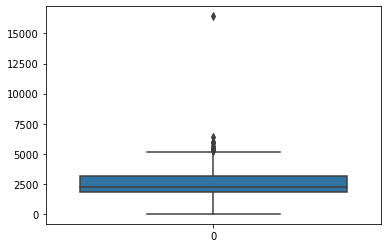

In [72]:
sns.boxplot(data=big_data['O2_SUM'])

In [73]:
big_data=big_data[big_data['O2_SUM']<10000]

In [76]:
big_data=big_data[big_data['RASHOD_SUM']<1000000]

<AxesSubplot:xlabel='TST'>

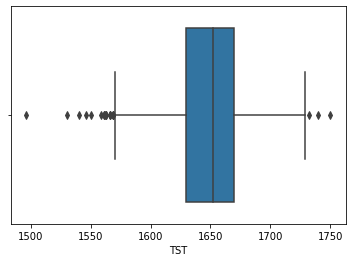

In [80]:
sns.boxplot(big_data['TST'])

In [109]:
corr=big_data.corr()

<AxesSubplot:>

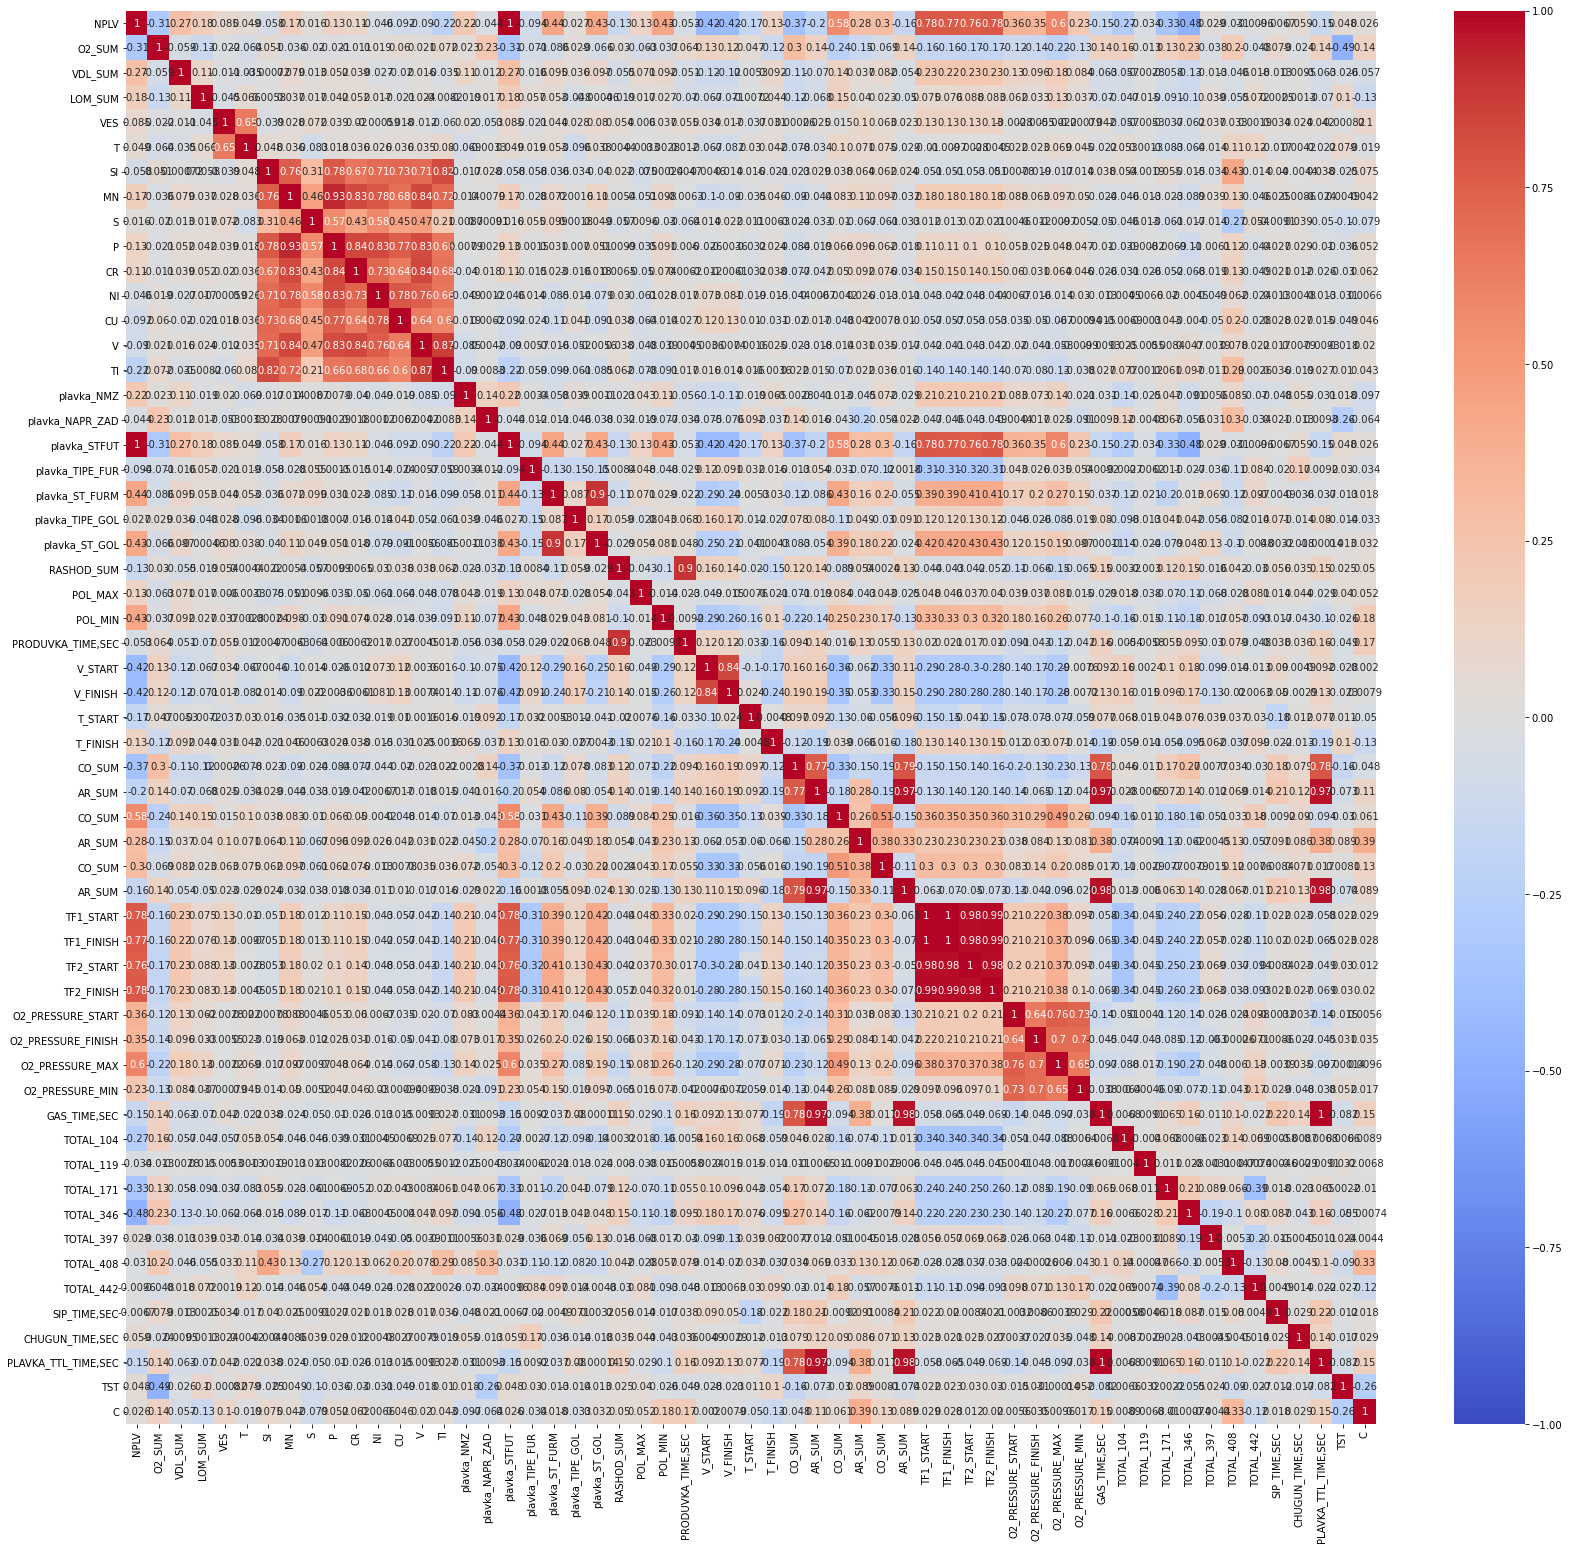

In [110]:
figure(figsize=(28, 26))
sns.heatmap(corr, annot=True, vmin=-1, vmax=1, cmap= 'coolwarm')

In [111]:
X_train=big_data.drop(['TST','C'], axis=1)
Y_train=big_data[['NPLV','TST','C']]

In [112]:
X_train

,NPLV,O2_SUM,VDL_SUM,LOM_SUM,VES,T,SI,MN,S,P,...,TOTAL_104,TOTAL_119,TOTAL_171,TOTAL_346,TOTAL_397,TOTAL_408,TOTAL_442,"SIP_TIME,SEC","CHUGUN_TIME,SEC","PLAVKA_TTL_TIME,SEC"
0,510008,2909.0,25,76200,263700.0,1396.0,0.44,0.22,0.023,0.097,...,0.0,0.0,980.0,2950.0,0.0,14080.0,2960.0,1795,412,2579
1,510009,2182.0,25,78600,264500.0,1419.0,0.68,0.20,0.017,0.087,...,1060.0,0.0,960.0,2930.0,0.0,18830.0,0.0,2670,1384,4004
2,510010,2841.0,48,76300,263800.0,1384.0,0.56,0.26,0.017,0.096,...,990.0,0.0,1050.0,2990.0,0.0,16080.0,2960.0,1892,551,2904
3,510011,10.0,25,84100,264000.0,1401.0,0.48,0.27,0.018,0.091,...,550.0,0.0,980.0,3620.0,0.0,22150.0,0.0,3304,429,3291
4,510012,3225.0,25,76100,263300.0,1422.0,0.47,0.23,0.018,0.096,...,2050.0,0.0,1000.0,2930.0,0.0,19550.0,3010.0,2315,558,2895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2057,512317,1649.0,25,80600,266300.0,1407.0,0.48,0.28,0.022,0.103,...,0.0,0.0,0.0,0.0,0.0,11930.0,3130.0,2245,86187,2286
2058,512318,1917.0,96,73600,267200.0,1415.0,0.38,0.28,0.019,0.099,...,0.0,0.0,0.0,0.0,0.0,14640.0,2890.0,2815,85754,3084
2059,512319,1660.0,48,76600,266800.0,1405.0,0.50,0.30,0.017,0.104,...,0.0,0.0,0.0,960.0,0.0,19210.0,2820.0,3947,697,3843
2060,512320,2968.0,65,64200,276100.0,1398.0,0.61,0.31,0.025,0.115,...,0.0,0.0,0.0,1380.0,0.0,19420.0,2830.0,2905,83512,3305


In [113]:
Y_train

,NPLV,TST,C
0,510008,1690,0.060
1,510009,1683,0.097
2,510010,1662,0.091
3,510011,1609,0.410
4,510012,1682,0.120
...,...,...,...
2057,512317,1655,0.035
2058,512318,1626,0.145
2059,512319,1643,0.087
2060,512320,1615,0.141
